In [39]:
import numpy as np
import open3d as o3d
import pathlib
import re
from ipywidgets import interact
from lib.datasets.kitti_utils import Calibration
import cv2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from pathlib import Path
from tools.sample_util import SampleDatabase
from tools.dataset_util import Dataset
test_dir = Path("/mnt/e/DataSet/kitti/kitti_inst_database/test")
np.random.seed(0)
import random
random.seed(0)
random_flip = 0
database = SampleDatabase("/mnt/e/DataSet/kitti/kitti_inst_database/", random_flip=random_flip)
dataset = Dataset("train", r"/mnt/e/DataSet/kitti")

In [118]:
idx =6309

calib_ = dataset.get_calib(idx)
image, depth = dataset.get_image_with_depth(idx, use_penet=False)
ground, non_ground = dataset.get_lidar_with_ground(idx, fov=True)
plane_ = dataset.get_plane(idx)
grid = dataset.get_grid(idx)
samples = database.get_samples(ground, non_ground, calib_, plane_, grid)
image_, depth_, samples_ = database.add_samples_to_scene(samples, image, depth, use_edge_blur=True)


-3.029946439300559
-2.1617710409087634
-0.7667485566217189
-3.3539934233592015
-4.4503986461926575
-0.9823239463364791
-0.6472052535766193


In [82]:
from tools.visualize_util import show_o3d
from tools.sample_util import to3d

sample = samples[4]
cord_0, rgb_0 = sample.get_points()
cord_1, rgb_1 = sample.get_points(True)
rgb_0 = np.ones_like(cord_0) + np.array([0, 0, 255])
rgb_1 = np.ones_like(cord_1) + np.array([255, 0, 0])
cord = np.concatenate([cord_0, cord_1], axis=0)
rgb = np.concatenate([rgb_0, rgb_1], axis=0)

show_o3d(cord, rgb, bbox3d=sample.bbox3d_)

sample.bbox3d_

array([-7.42183152,  1.07104441, 42.25290603,  3.23      ,  1.41      ,
        1.57      , -1.8797929 ])

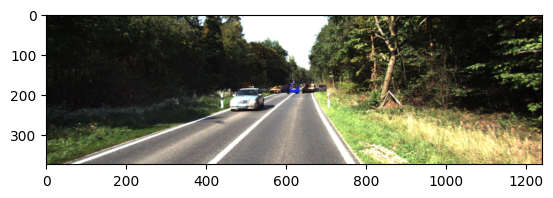

(array([-0.21984917,  1.6888845 , 45.94957224,  3.95      ,  1.69      ,
         1.58      , -1.99107223]),
 array([3.58, 1.65, 8.76], dtype=float32))

In [127]:
from tools.visualize_util import plt_show
sample = samples[4]
i = image_
plt_show(i)
cv2.imwrite("i.png", i)
sample.bbox3d_, sample.label.pos

In [20]:
test_image = samples[1].image_.copy()
test_depth = samples[1].depth_.copy()
gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

# 寻找轮廓
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour = max(contours, key=cv2.contourArea)
# 可以在此处处理轮廓，例如画出轮廓等

mask = np.zeros_like(thresh, dtype=np.uint8)
cv2.fillPoly(mask, [largest_contour], color=255)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
# 腐蚀操作
dilated = cv2.dilate(mask, kernel, iterations=1)  # 迭代次数为1
# 膨胀操作
eroded = cv2.erode(dilated, kernel, iterations=1)  # 迭代次数为1

mask = ((eroded == 255) & (thresh == 0)).astype(np.uint8)


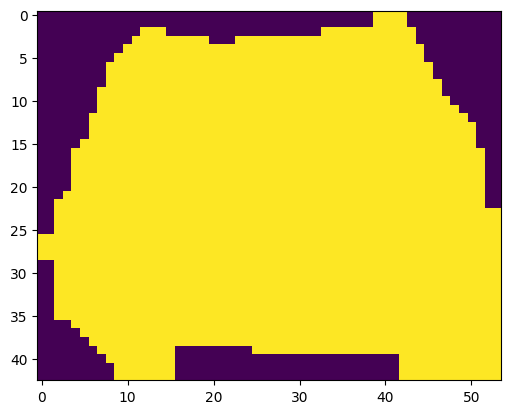

In [21]:
plt_show(eroded, rgb=False)

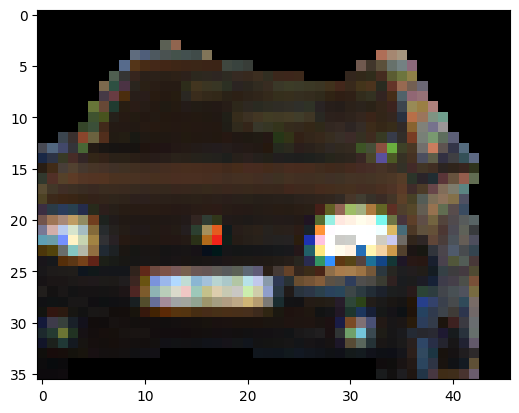

In [15]:
revise_image = cv2.inpaint(test_image, mask, 5, cv2.INPAINT_TELEA)
plt_show(revise_image)

In [16]:
cv2.imwrite("i.png", cv2.cvtColor(revise_image, cv2.COLOR_BGR2RGB))

True

In [17]:
samples[3].bbox3d_, samples[3].label.pos

(array([-2.47350363,  1.44091925, 59.50034874,  4.63      ,  1.45      ,
         1.65      ,  2.0233292 ]),
 array([-10.38,   2.04,  20.48], dtype=float32))

In [476]:
import open3d as o3d

pcd = o3d.io.read_point_cloud("/mnt/e/DataSet/kitti_completion/cars/frame_0_car_0.pcd")
o3d.visualization.draw_geometries([pcd])

In [484]:
bbox = np.loadtxt("/mnt/e/DataSet/kitti_completion/bboxes/frame_0_car_0.txt")
bbox

array([[ 4.1722902 , -1.98153735, -1.54747295],
       [ 4.1722902 , -3.83153735, -1.54747295],
       [ 9.1028541 , -3.83153735, -1.54747295],
       [ 9.1028541 , -1.98153735, -1.54747295],
       [ 4.1722902 , -1.98153735, -0.03755285],
       [ 4.1722902 , -3.83153735, -0.03755285],
       [ 9.1028541 , -3.83153735, -0.03755285],
       [ 9.1028541 , -1.98153735, -0.03755285]])

In [486]:
center = (bbox.min(0) + bbox.max(0)) / 2
bbox -= center
yaw = np.arctan2(bbox[3, 1] - bbox[0, 1], bbox[3, 0] - bbox[0, 0])
yaw

0.0

In [487]:
bbox

array([[-2.46528195,  0.925     , -0.75496005],
       [-2.46528195, -0.925     , -0.75496005],
       [ 2.46528195, -0.925     , -0.75496005],
       [ 2.46528195,  0.925     , -0.75496005],
       [-2.46528195,  0.925     ,  0.75496005],
       [-2.46528195, -0.925     ,  0.75496005],
       [ 2.46528195, -0.925     ,  0.75496005],
       [ 2.46528195,  0.925     ,  0.75496005]])